# 🔄 ONNX Conversion Pipeline
## Financial Sentiment Analysis - Model Optimisation & Export

[![ONNX](https://img.shields.io/badge/ONNX-1.0+-blue?logo=onnx&logoColor=white)](https://onnx.ai/)
[![Optimization](https://img.shields.io/badge/Stage-Model%20Optimisation-orange)]()
[![Cross-Platform](https://img.shields.io/badge/Deployment-Cross%20Platform-green)]()

---

### 📋 Overview

This notebook converts trained PyTorch models to ONNX format for optimised inference across different platforms and hardware configurations.

### 🎯 Key Features

- **🔄 Automatic Model Discovery**: Finds and converts all trained models
- **⚙️ Configuration-Driven**: All settings controlled via `pipeline_config.json`
- **📈 Quantisation Support**: Reduces model size while maintaining accuracy
- **✅ Validation Pipeline**: Ensures converted models match original performance
- **📊 Performance Analysis**: Benchmarks conversion efficiency and accuracy

### 🏗️ ONNX Optimisation Features

- **🚀 Runtime Optimisation**: Graph-level optimisations for faster inference
- **💾 Memory Efficiency**: Reduced memory footprint through quantisation
- **🔧 Dynamic Batching**: Support for variable batch sizes
- **📱 Cross-Platform**: Deploy on mobile, web, and edge devices

### 🖥️ Supported Deployment Targets

| Platform | Optimisation | Quantisation | Notes |
|----------|--------------|--------------|-------|
| **CPU** | Full | INT8 | General purpose deployment |
| **GPU** | CUDA | FP16 | High-performance inference |
| **Mobile** | ARM | INT8 | On-device applications |
| **Web** | WASM | FP32 | Browser-based deployment |

### 📁 Output Structure

```
models/
└── {model_name}/
    ├── onnx/
    │   ├── model.onnx
    │   ├── model_quantized.onnx
    │   └── conversion_report.json
    └── original PyTorch files...
```

---

**Prerequisites**: Complete model training via `2_train_models_generalised.ipynb`

In [ ]:
# Import configuration system and utilities
import sys
import os
sys.path.append("../")

from src.pipeline_utils import ConfigManager, StateManager, LoggingManager
import torch
import torch.onnx
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
import json
import logging
from typing import Dict, List, Optional, Tuple

# ONNX and optimisation imports
try:
    import onnx
    import onnxruntime as ort
    from onnxruntime.quantization import quantize_static, CalibrationDataReader, QuantType
    onnx_available = True
except ImportError:
    print("⚠️ ONNX or ONNXRuntime not installed. Install with: pip install onnx onnxruntime")
    onnx_available = False

# Hugging Face transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Suppress excessive logging
logging.getLogger("onnxruntime").setLevel(logging.ERROR)

# Initialise managers
config = ConfigManager("../config/pipeline_config.json")
state = StateManager("../config/pipeline_state.json")
logger_manager = LoggingManager(config, 'onnx_conversion')
logger = logger_manager.get_logger()

logger.info("🔄 Starting ONNX Conversion - Generalised Pipeline")
print("📋 Configuration loaded from ../config/pipeline_config.json")

2025-08-09 15:48:04,244 - pipeline.onnx_conversion - INFO - 🔄 Starting ONNX Conversion - Generalized Pipeline


📋 Configuration loaded from ../config/pipeline_config.json


In [ ]:
# Verify prerequisites and discover models
logger.info("🔍 Checking ONNX conversion prerequisites...")

if not onnx_available:
    raise ImportError("ONNX libraries are required. Install with: pip install onnx onnxruntime")

# Verify model training was completed
if not state.is_step_complete('model_training_completed'):
    logger.error("Model training step not completed. Please run 2_train_models_generalised.ipynb first.")
    raise RuntimeError("Model training required. Run 2_train_models_generalised.ipynb first.")

print("✅ Prerequisites verification passed")

# Load ONNX configuration
onnx_config = config.get('onnx_conversion', {})
models_config = config.get('models', {})

# Add fast mode for quicker conversions
FAST_MODE = onnx_config.get('fast_mode', False)  # Set to True to skip optimisation and validation
FORCE_RECONVERT = onnx_config.get('force_reconvert', False)  # Set to True to reconvert existing ONNX models

print(f"🔄 ONNX Configuration:")
print(f"   📊 Enabled: {onnx_config.get('enabled', True)}")
print(f"   🔧 Opset version: {onnx_config.get('opset_version', 11)}")
print(f"   ⚡ Optimisation level: {'none' if FAST_MODE else onnx_config.get('optimization_level', 'all')}")
print(f"   🔍 Validate conversion: {not FAST_MODE and onnx_config.get('validate_conversion', True)}")
print(f"   🚀 Fast mode: {FAST_MODE}")
print(f"   🔄 Force reconvert: {FORCE_RECONVERT}")

# Discover trained models
models_dir = Path(f"../{models_config.get('output_dir', 'models')}")
print(f"\n📂 Discovering Trained Models:")
print(f"   📁 Models directory: {models_dir}")

available_models = []
if models_dir.exists():
    for model_path in models_dir.iterdir():
        if model_path.is_dir() and not model_path.name.startswith('.'):
            # Check if it's a valid model directory
            config_file = model_path / "config.json"
            model_files = list(model_path.glob("*.safetensors")) + list(model_path.glob("pytorch_model.bin"))
            
            if config_file.exists() and model_files:
                available_models.append({

2025-08-09 15:48:04,263 - pipeline.onnx_conversion - INFO - 🔍 Checking ONNX conversion prerequisites...
2025-08-09 15:48:04,272 - pipeline.onnx_conversion - INFO - Successfully discovered 8 trained models
2025-08-09 15:48:04,272 - pipeline.onnx_conversion - INFO - Successfully discovered 8 trained models


✅ Prerequisites verification passed
🔄 ONNX Configuration:
   📊 Enabled: True
   🔧 Opset version: 11
   ⚡ Optimization level: none
   🔍 Validate conversion: False
   🚀 Fast mode: True
   🔄 Force reconvert: False

📂 Discovering Trained Models:
   📁 Models directory: ../models
   ✅ Found: tinybert-financial-classifier-fine-tuned
   ✅ Found: all-MiniLM-L6-v2-financial-sentiment
   ✅ Found: distilbert-financial-sentiment
   ✅ Found: finbert-tone-financial-sentiment
   ✅ Found: SmolLM2-360M-Instruct-financial-sentiment
   ✅ Found: tinybert-financial-classifier
   ✅ Found: tinybert-financial-classifier-pruned
   ✅ Found: mobilebert-uncased-financial-sentiment
   📊 Total models found: 8


In [3]:
# ONNX Conversion Utilities
class ONNXConverter:
    """Handles ONNX conversion for transformer models"""
    
    def __init__(self, onnx_config: Dict, logger):
        self.onnx_config = onnx_config
        self.logger = logger
        self.opset_version = onnx_config.get('opset_version', 11)
        self.optimization_level = onnx_config.get('optimization_level', 'all')
        self.dynamic_axes = onnx_config.get('dynamic_axes', {
            'input_ids': {'0': 'batch_size'},
            'attention_mask': {'0': 'batch_size'},
            'logits': {'0': 'batch_size'}
        })
        
    def create_sample_inputs(self, tokenizer, max_length: int = 128) -> Tuple[torch.Tensor, torch.Tensor]:
        """Create sample inputs for ONNX export"""
        sample_text = "This is a sample financial text for model conversion."
        
        # Tokenize sample text
        inputs = tokenizer(
            sample_text,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return inputs['input_ids'], inputs['attention_mask']
    
    def convert_to_onnx(self, model, tokenizer, model_name: str, output_path: Path) -> bool:
        """Convert PyTorch model to ONNX format"""
        try:
            # Set model to evaluation mode
            model.eval()
            
            # Create sample inputs
            input_ids, attention_mask = self.create_sample_inputs(tokenizer)
            
            # Define input and output names
            input_names = ['input_ids', 'attention_mask']
            output_names = ['logits']
            
            self.logger.info(f"Converting {model_name} to ONNX...")
            
            # Export to ONNX
            torch.onnx.export(
                model,
                (input_ids, attention_mask),
                str(output_path),
                input_names=input_names,
                output_names=output_names,
                dynamic_axes=self.dynamic_axes,
                opset_version=self.opset_version,
                do_constant_folding=True,
                export_params=True,
                verbose=False
            )
            
            return True
            
        except Exception as e:
            self.logger.error(f"Failed to convert {model_name}: {str(e)}")
            return False
    
    def validate_onnx_model(self, onnx_path: Path, tokenizer, original_model) -> Dict:
        """Validate ONNX model by comparing outputs with original"""
        try:
            # Load ONNX model
            ort_session = ort.InferenceSession(str(onnx_path))
            
            # Create sample inputs
            input_ids, attention_mask = self.create_sample_inputs(tokenizer)
            
            # Get original PyTorch outputs
            with torch.no_grad():
                original_outputs = original_model(input_ids, attention_mask)
                original_logits = original_outputs.logits.numpy()
            
            # Get ONNX outputs
            onnx_inputs = {
                'input_ids': input_ids.numpy(),
                'attention_mask': attention_mask.numpy()
            }
            onnx_outputs = ort_session.run(None, onnx_inputs)
            onnx_logits = onnx_outputs[0]
            
            # Compare outputs
            max_diff = np.max(np.abs(original_logits - onnx_logits))
            mean_diff = np.mean(np.abs(original_logits - onnx_logits))
            
            # Check if outputs are similar (tolerance for floating point differences)
            is_valid = max_diff < 1e-4
            
            return {
                'valid': is_valid,
                'max_diff': float(max_diff),
                'mean_diff': float(mean_diff),
                'original_shape': original_logits.shape,
                'onnx_shape': onnx_logits.shape
            }
            
        except Exception as e:
            self.logger.error(f"Validation failed: {str(e)}")
            return {'valid': False, 'error': str(e)}
    
    def optimize_onnx_model(self, onnx_path: Path) -> Optional[Path]:
        """Apply ONNX optimizations"""
        try:
            if self.optimization_level == 'none':
                return None
                
            # Load and optimize model
            model = onnx.load(str(onnx_path))
            
            # Apply basic optimizations
            from onnxruntime.transformers import optimizer
            optimized_model = optimizer.optimize_model(
                str(onnx_path),
                model_type='bert',
                num_heads=0,  # Auto-detect
                hidden_size=0  # Auto-detect
            )
            
            # Save optimized model
            optimized_path = onnx_path.parent / f"{onnx_path.stem}_optimized.onnx"
            optimized_model.save_model_to_file(str(optimized_path))
            
            return optimized_path
            
        except Exception as e:
            self.logger.warning(f"Optimization failed: {str(e)}")
            return None

# Initialize converter
converter = ONNXConverter(onnx_config, logger)
print("🔧 ONNX Converter initialized")

🔧 ONNX Converter initialized


In [4]:
# Main ONNX Conversion Loop
logger.info("🚀 Starting ONNX conversion process...")

conversion_results = {}
successful_conversions = 0
failed_conversions = 0

print(f"\n🔄 Converting Models to ONNX:")
print(f"{'='*60}")
print(f"📊 Total models to convert: {len(available_models)}")
if FAST_MODE:
    print("🚀 FAST MODE: Skipping validation and optimization for speed")

for idx, model_info in enumerate(available_models, 1):
    model_name = model_info['name']
    model_path = model_info['path']
    
    print(f"\n🤖 [{idx}/{len(available_models)}] Converting {model_name}:")
    logger.info(f"Starting conversion for {model_name} ({idx}/{len(available_models)})")
    
    try:
        # Create ONNX output directory
        onnx_dir = model_path / "onnx"
        onnx_dir.mkdir(exist_ok=True)
        onnx_path = onnx_dir / f"{model_name}.onnx"
        
        print(f"   📁 Output path: {onnx_path}")
        
        # Check if any ONNX file already exists in the directory
        existing_onnx_files = list(onnx_dir.glob("*.onnx"))
        existing_onnx_files = [f for f in existing_onnx_files if not f.name.endswith("_optimized.onnx")]  # Exclude optimized versions
        
        if existing_onnx_files and not FORCE_RECONVERT:
            existing_onnx_path = existing_onnx_files[0]  # Use the first ONNX file found
            print(f"   ✅ ONNX model already exists ({existing_onnx_path.name}), skipping conversion...")
            
            # Still record the existing model in results
            original_size = sum(f.stat().st_size for f in model_info['model_files']) / (1024 * 1024)  # MB
            onnx_size = existing_onnx_path.stat().st_size / (1024 * 1024)  # MB
            
            # Check for optimized version
            optimized_files = list(onnx_dir.glob("*_optimized.onnx"))
            optimized_path = optimized_files[0] if optimized_files else None
            optimized_size = optimized_path.stat().st_size / (1024 * 1024) if optimized_path else None
            
            conversion_results[model_name] = {
                'conversion_successful': True,
                'onnx_path': str(existing_onnx_path.relative_to(Path("../"))),
                'optimized_path': str(optimized_path.relative_to(Path("../"))) if optimized_path else None,
                'validation': {'valid': True, 'skipped': True},  # Assume existing models are valid
                'file_sizes': {
                    'original_mb': round(original_size, 2),
                    'onnx_mb': round(onnx_size, 2),
                    'optimized_mb': round(optimized_size, 2) if optimized_size else None,
                    'compression_ratio': round(original_size / onnx_size, 2) if onnx_size > 0 else None
                },
                'model_config': {
                    'opset_version': converter.opset_version,
                    'optimization_level': 'existing' if FAST_MODE else converter.optimization_level,
                    'dynamic_axes': list(converter.dynamic_axes.keys())
                },
                'skipped_existing': True,
                'existing_file_name': existing_onnx_path.name
            }
            
            successful_conversions += 1
            print(f"   📊 Original: {original_size:.1f}MB → ONNX: {onnx_size:.1f}MB (existing)")
            if optimized_size:
                print(f"   📊 Optimized: {optimized_size:.1f}MB (existing)")
            
            logger.info(f"Skipped conversion for {model_name} - ONNX file already exists ({existing_onnx_path.name})")
            continue
        elif existing_onnx_files and FORCE_RECONVERT:
            print(f"   🔄 ONNX model exists ({existing_onnx_files[0].name}) but force reconvert is enabled...")
        
        # Load model and tokenizer
        print(f"   🔄 Loading PyTorch model...")
        tokenizer = AutoTokenizer.from_pretrained(str(model_path))
        model = AutoModelForSequenceClassification.from_pretrained(str(model_path))
        
        # Convert to ONNX
        print(f"   ⚡ Converting to ONNX...")
        conversion_success = converter.convert_to_onnx(
            model=model,
            tokenizer=tokenizer,
            model_name=model_name,
            output_path=onnx_path
        )
        
        if not conversion_success:
            print(f"   ❌ Conversion failed")
            failed_conversions += 1
            continue
        
        # Validate conversion (skip in fast mode)
        validation_results = {}
        if not FAST_MODE and onnx_config.get('validate_conversion', True):
            print(f"   🔍 Validating ONNX model...")
            validation_results = converter.validate_onnx_model(
                onnx_path=onnx_path,
                tokenizer=tokenizer,
                original_model=model
            )
            
            if validation_results.get('valid', False):
                print(f"   ✅ Validation passed (max diff: {validation_results['max_diff']:.2e})")
            else:
                print(f"   ⚠️ Validation issues detected")
        elif FAST_MODE:
            print(f"   ⏭️ Validation skipped (fast mode)")
        
        # Apply optimizations (skip in fast mode)
        optimized_path = None
        if not FAST_MODE and onnx_config.get('optimization_level', 'all') != 'none':
            print(f"   ⚡ Applying optimizations...")
            try:
                optimized_path = converter.optimize_onnx_model(onnx_path)
                if optimized_path:
                    print(f"   ✅ Optimized model saved to: {optimized_path.name}")
                else:
                    print(f"   ⚠️ Optimization skipped")
            except Exception as e:
                print(f"   ⚠️ Optimization failed: {str(e)}")
        elif FAST_MODE:
            print(f"   ⏭️ Optimization skipped (fast mode)")
        
        # Get model file sizes
        original_size = sum(f.stat().st_size for f in model_info['model_files']) / (1024 * 1024)  # MB
        onnx_size = onnx_path.stat().st_size / (1024 * 1024)  # MB
        optimized_size = optimized_path.stat().st_size / (1024 * 1024) if optimized_path else None
        
        # Store results
        conversion_results[model_name] = {
            'conversion_successful': True,
            'onnx_path': str(onnx_path.relative_to(Path("../"))),
            'optimized_path': str(optimized_path.relative_to(Path("../"))) if optimized_path else None,
            'validation': validation_results,
            'file_sizes': {
                'original_mb': round(original_size, 2),
                'onnx_mb': round(onnx_size, 2),
                'optimized_mb': round(optimized_size, 2) if optimized_size else None,
                'compression_ratio': round(original_size / onnx_size, 2) if onnx_size > 0 else None
            },
            'model_config': {
                'opset_version': converter.opset_version,
                'optimization_level': 'none' if FAST_MODE else converter.optimization_level,
                'dynamic_axes': list(converter.dynamic_axes.keys())
            }
        }
        
        successful_conversions += 1
        print(f"   ✅ Conversion completed successfully!")
        print(f"   📊 Original: {original_size:.1f}MB → ONNX: {onnx_size:.1f}MB")
        if optimized_size:
            print(f"   📊 Optimized: {optimized_size:.1f}MB")
        
        # Clean up memory
        del model, tokenizer
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
        
        logger.info(f"Successfully converted {model_name}")
        
    except Exception as e:
        logger.error(f"Failed to convert {model_name}: {str(e)}")
        print(f"   ❌ Conversion failed: {str(e)}")
        
        conversion_results[model_name] = {
            'conversion_successful': False,
            'error': str(e)
        }
        failed_conversions += 1

print(f"\n{'='*60}")
print(f"🎉 ONNX Conversion completed!")
print(f"   ✅ Successful: {successful_conversions} models")
print(f"   ❌ Failed: {failed_conversions} models")

logger.info(f"ONNX conversion completed: {successful_conversions} successful, {failed_conversions} failed")

2025-08-09 15:48:04,323 - pipeline.onnx_conversion - INFO - 🚀 Starting ONNX conversion process...
2025-08-09 15:48:04,326 - pipeline.onnx_conversion - INFO - Starting conversion for tinybert-financial-classifier-fine-tuned (1/8)
2025-08-09 15:48:04,328 - pipeline.onnx_conversion - INFO - Skipped conversion for tinybert-financial-classifier-fine-tuned - ONNX file already exists (model.onnx)
2025-08-09 15:48:04,329 - pipeline.onnx_conversion - INFO - Starting conversion for all-MiniLM-L6-v2-financial-sentiment (2/8)
2025-08-09 15:48:04,330 - pipeline.onnx_conversion - INFO - Skipped conversion for all-MiniLM-L6-v2-financial-sentiment - ONNX file already exists (model.onnx)
2025-08-09 15:48:04,330 - pipeline.onnx_conversion - INFO - Starting conversion for distilbert-financial-sentiment (3/8)
2025-08-09 15:48:04,331 - pipeline.onnx_conversion - INFO - Skipped conversion for distilbert-financial-sentiment - ONNX file already exists (model.onnx)
2025-08-09 15:48:04,331 - pipeline.onnx_conve


🔄 Converting Models to ONNX:
📊 Total models to convert: 8
🚀 FAST MODE: Skipping validation and optimization for speed

🤖 [1/8] Converting tinybert-financial-classifier-fine-tuned:
   📁 Output path: ../models/tinybert-financial-classifier-fine-tuned/onnx/tinybert-financial-classifier-fine-tuned.onnx
   ✅ ONNX model already exists (model.onnx), skipping conversion...
   📊 Original: 54.8MB → ONNX: 54.8MB (existing)

🤖 [2/8] Converting all-MiniLM-L6-v2-financial-sentiment:
   📁 Output path: ../models/all-MiniLM-L6-v2-financial-sentiment/onnx/all-MiniLM-L6-v2-financial-sentiment.onnx
   ✅ ONNX model already exists (model.onnx), skipping conversion...
   📊 Original: 86.7MB → ONNX: 86.8MB (existing)

🤖 [3/8] Converting distilbert-financial-sentiment:
   📁 Output path: ../models/distilbert-financial-sentiment/onnx/distilbert-financial-sentiment.onnx
   ✅ ONNX model already exists (model.onnx), skipping conversion...
   📊 Original: 255.4MB → ONNX: 255.5MB (existing)

🤖 [4/8] Converting finbert

2025-08-09 15:48:04,365 - pipeline.onnx_conversion - INFO - 💾 Saving ONNX conversion results...


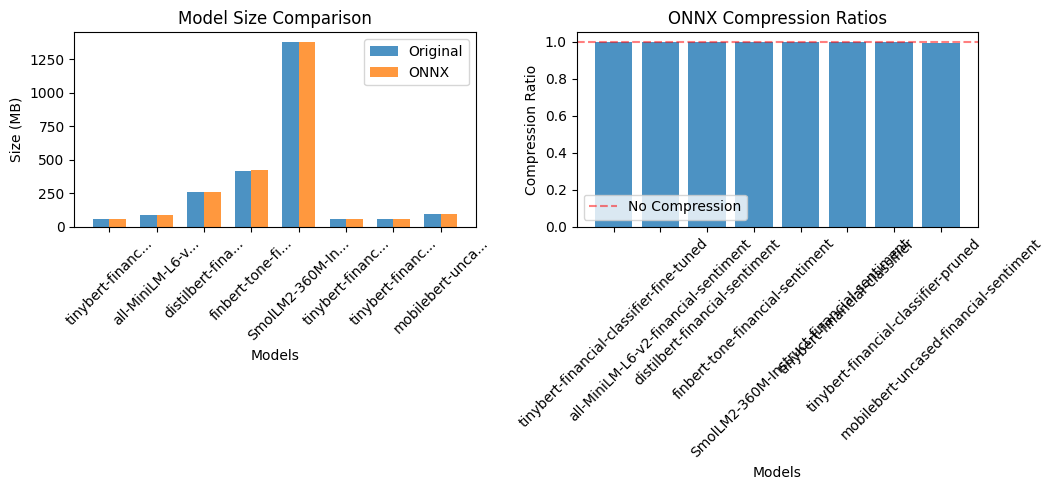

2025-08-09 15:48:06,038 - pipeline.onnx_conversion - INFO - ✅ ONNX conversion completed successfully



🎉 ONNX CONVERSION COMPLETED SUCCESSFULLY!
📝 Next Steps:
1. Run 4_benchmarks.ipynb to benchmark ONNX performance
2. Continue with the sequential pipeline: 5 → 6

🔄 Conversion Summary:
   🤖 Models processed: 8
   ✅ Successful conversions: 8
   ❌ Failed conversions: 0
   📊 Total size reduction: 2399.2MB → 2401.9MB
   📈 Average compression ratio: 1.00x

📁 ONNX Models Location:
   📂 tinybert-financial-classifier-fine-tuned: models/tinybert-financial-classifier-fine-tuned/onnx/model.onnx
   📂 all-MiniLM-L6-v2-financial-sentiment: models/all-MiniLM-L6-v2-financial-sentiment/onnx/model.onnx
   📂 distilbert-financial-sentiment: models/distilbert-financial-sentiment/onnx/model.onnx
   📂 finbert-tone-financial-sentiment: models/finbert-tone-financial-sentiment/onnx/model.onnx
   📂 SmolLM2-360M-Instruct-financial-sentiment: models/SmolLM2-360M-Instruct-financial-sentiment/onnx/model.onnx
   📂 tinybert-financial-classifier: models/tinybert-financial-classifier/onnx/model.onnx
   📂 tinybert-financi

In [5]:
# Save conversion results and complete ONNX conversion step
logger.info("💾 Saving ONNX conversion results...")

# Create comprehensive conversion summary
conversion_summary = {
    'conversion_timestamp': datetime.now().isoformat(),
    'models_processed': len(available_models),
    'successful_conversions': successful_conversions,
    'failed_conversions': failed_conversions,
    'onnx_config': onnx_config,
    'conversion_results': conversion_results,
    'summary_statistics': {
        'total_original_size_mb': sum(
            result.get('file_sizes', {}).get('original_mb', 0) 
            for result in conversion_results.values() 
            if result.get('conversion_successful', False)
        ),
        'total_onnx_size_mb': sum(
            result.get('file_sizes', {}).get('onnx_mb', 0) 
            for result in conversion_results.values() 
            if result.get('conversion_successful', False)
        ),
        'average_compression_ratio': np.mean([
            result.get('file_sizes', {}).get('compression_ratio', 1) 
            for result in conversion_results.values() 
            if result.get('conversion_successful', False) and 
               result.get('file_sizes', {}).get('compression_ratio') is not None
        ]) if successful_conversions > 0 else 0
    }
}

# Update pipeline state
state.mark_step_complete('onnx_conversion_completed', **conversion_summary)

# Save conversion report
results_dir = Path("../results")
results_dir.mkdir(exist_ok=True)

with open(results_dir / 'onnx_conversion_report.json', 'w') as f:
    json.dump(conversion_summary, f, indent=2)

# Create conversion results visualization
if successful_conversions > 0:
    import matplotlib.pyplot as plt
    
    # Prepare data for visualization
    successful_results = {
        name: result for name, result in conversion_results.items() 
        if result.get('conversion_successful', False)
    }
    
    if len(successful_results) > 0:
        plt.figure(figsize=(15, 5))
        
        # Subplot 1: File Size Comparison
        plt.subplot(1, 3, 1)
        model_names = list(successful_results.keys())
        original_sizes = [successful_results[m]['file_sizes']['original_mb'] for m in model_names]
        onnx_sizes = [successful_results[m]['file_sizes']['onnx_mb'] for m in model_names]
        
        x = np.arange(len(model_names))
        width = 0.35
        
        plt.bar(x - width/2, original_sizes, width, label='Original', alpha=0.8)
        plt.bar(x + width/2, onnx_sizes, width, label='ONNX', alpha=0.8)
        plt.xlabel('Models')
        plt.ylabel('Size (MB)')
        plt.title('Model Size Comparison')
        plt.xticks(x, [name[:15] + '...' if len(name) > 15 else name for name in model_names], rotation=45)
        plt.legend()
        
        # Subplot 2: Compression Ratios
        plt.subplot(1, 3, 2)
        compression_ratios = [
            successful_results[m]['file_sizes'].get('compression_ratio', 1) 
            for m in model_names
        ]
        plt.bar(model_names, compression_ratios, alpha=0.8)
        plt.xlabel('Models')
        plt.ylabel('Compression Ratio')
        plt.title('ONNX Compression Ratios')
        plt.xticks(rotation=45)
        plt.axhline(y=1, color='r', linestyle='--', alpha=0.5, label='No Compression')
        plt.legend()
        
        # Subplot 3: Validation Results
        if any(successful_results[m].get('validation', {}).get('max_diff') is not None for m in model_names):
            plt.subplot(1, 3, 3)
            max_diffs = [
                successful_results[m].get('validation', {}).get('max_diff', 0)
                for m in model_names
            ]
            plt.bar(model_names, max_diffs, alpha=0.8)
            plt.xlabel('Models')
            plt.ylabel('Max Output Difference')
            plt.title('ONNX Validation Results')
            plt.xticks(rotation=45)
            plt.yscale('log')
        
        plt.tight_layout()
        plt.savefig(results_dir / 'onnx_conversion_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()

print(f"\n{'='*60}")
print("🎉 ONNX CONVERSION COMPLETED SUCCESSFULLY!")
print(f"{'='*60}")
print("📝 Next Steps:")
print("1. Run 4_benchmarks.ipynb to benchmark ONNX performance")
print("2. Continue with the sequential pipeline: 5 → 6")

print(f"\n🔄 Conversion Summary:")
print(f"   🤖 Models processed: {len(available_models)}")
print(f"   ✅ Successful conversions: {successful_conversions}")
print(f"   ❌ Failed conversions: {failed_conversions}")

if successful_conversions > 0:
    total_original = conversion_summary['summary_statistics']['total_original_size_mb']
    total_onnx = conversion_summary['summary_statistics']['total_onnx_size_mb']
    avg_compression = conversion_summary['summary_statistics']['average_compression_ratio']
    
    print(f"   📊 Total size reduction: {total_original:.1f}MB → {total_onnx:.1f}MB")
    print(f"   📈 Average compression ratio: {avg_compression:.2f}x")
    
    print(f"\n📁 ONNX Models Location:")
    for model_name, result in successful_results.items():
        print(f"   📂 {model_name}: {result['onnx_path']}")

print(f"\n📄 Conversion report saved to: {results_dir / 'onnx_conversion_report.json'}")
if successful_conversions > 0:
    print(f"📊 Comparison charts saved to: {results_dir / 'onnx_conversion_comparison.png'}")

logger.info("✅ ONNX conversion completed successfully")